<a href="https://colab.research.google.com/github/wisdomscode/AI-Lab-Deep-Learning-PyTorch/blob/main/AI_Lab_5_Sea_Life_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEA LIFE CLASSIFICATION

## Indroction

Oceans cover two-thirds of the planet. In this assignment, you will build a classifier to tell several types of creatures apart.

Start the lab, run the imports, and get ready to do some classification!

**Prepare the Environment**

In [ ]:
import os

from collections import Counter

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

In [ ]:
pip install torchinfo

**Task 1.5.1:**

Get the GPU device, if it is available.  Store the device name in the variable `device`.

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

### Load the Data

The data for this assignment is contained in the directory `sea_creatures`. In this directory, there are two folders.  We'll use `train` to train our classification model, and then submit predictions about the `test` images to the grader.

In [ ]:
os.listdir("sea_creatures")

# output
['test', 'train']

**Find the names of the classes**


**Task 1.5.2:**

Find the names of the classes we will be working with.  Images for each class are inside folders within the `sea_creatures/train` folder.  Make a list of the class names (each corresponding to a directory name). Your list should be named `classes`.

In [ ]:
data_dir = 'sea_creatures/'
train_dir = os.path.join(data_dir, 'train')
classes = os.listdir(train_dir)
print(classes)

# output
['Puffers', 'Sea Urchins', 'Turtle_Tortoise', 'Whale', 'Jelly Fish', 'Sharks', 'Octopus', 'Sea Rays', 'Dolphin']


**Build a transformer pipeline**
**Task 1.5.3:**

Build a transformer pipeline.  It should ensure the images are in RGB format, scale them to 224$\times$224 pixels, and convert them into a PyTorch tensor.  You will probably find `ConvertToRGB` useful.

In [ ]:
height = 224
width = 224


class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img


transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((height, width)),
    transforms.ToTensor(),
])

print(transform)

#output

height = 224
width = 224


class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img


transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((height, width)),
    transforms.ToTensor(),
])

print(transform)
Compose(
    <__main__.ConvertToRGB object at 0x7f782b4aa190>
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

**Test that the transformer pipeline is working**

**Task 1.5.4:**

Test that the transformer pipeline is working.  Load in the specified training image and transform it.  Check that you get a 3$\times$224$\times$224 tensor.

In [ ]:
# Load the image
sample_file = "sea_creatures/train/Dolphin/10004986625_0f786ab86b_b.jpg"

image = Image.open(sample_file)

# Apply transformation
transformed_image = transform(image)
print(transformed_image.shape)

# output
torch.Size([3, 224, 224])


**Create the training data DataSet**

**Task 1.5.5:**

Create a `DataSet` for the training data (using the `ImageFolder` subclass). It should apply the transformer pipeline.


In [ ]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)
print("Image size", dataset[0][0].shape)
print("Label", dataset[0][1])

# output
Image size torch.Size([3, 224, 224])
Label 0

**Calculate the class distribution**

**Task 1.5.6:**

Calculate the class distribution.  Store this in the variable `class_distribution` as a dictionary.  The keys should be the class names.  The values should be the number of training samples for the class.

In [ ]:
# This will get us the counts, but notice that the keys are the class indices,
# not the class names.
counts = Counter(x[1] for x in tqdm(dataset))
print("The counts dictionary:", counts)

# This dictionary maps class names to their index.
print("The class_to_idx dictionary:", dataset.class_to_idx)

# Use both of these to construct the desired dictionary

# Reverse the class_to_idx dictionary to get index -> class mapping
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

# Convert counts to use class names instead of indices
class_distribution = {idx_to_class[idx]: count for idx, count in counts.items()}

print(class_distribution)

#output

100%
{'Dolphin': 711, 'Jelly Fish': 752, 'Octopus': 495, 'Puffers': 488, 'Sea Rays': 451, 'Sea Urchins': 524, 'Sharks': 533, 'Turtle_Tortoise': 1716, 'Whale': 512}

## Transform the Data

**Create a DataLoader**

**Task 1.5.7:**

Create a `DataLoader` that loads from this `DataSet` in batches of 32.

In [ ]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Get one batch
first_batch = next(iter(dataset_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")

#output
Shape of one batch: torch.Size([32, 3, 224, 224])
Shape of labels: torch.Size([32])

**Calculate the mean and standard deviation of each channel in this data set**

**Task 1.5.8:**

Calculate the mean and standard deviation of each channel in this data set.

Fill the missing lines in the `get_mean_std` function and invoke it with the right dataset.

This will calculate the correct values for `mean` and `std`.

In [ ]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    # Compute the mean from the channels_sum and num_batches
    mean = channels_sum / num_batches
    # Compute the standard deviation form channels_squared_sum, num_batches,
    # and the mean.
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std


mean, std = get_mean_std(dataset_loader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

# output
Mean: tensor([0.2992, 0.4125, 0.4588])
Standard deviation: tensor([0.2697, 0.2404, 0.2658])

**Build a transformer pipeline that normalizes the channels**

**Task 1.5.9:**

Build a new transformer pipeline that normalizes the channels according to the mean and standard deviation above. The pipeline should be assigned to the variable `transform_norm`. Afterwards, use the pipeline to create a normalized data set and store it in the variable `norm_dataset`.

In [ ]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]

)
print(transform_norm)

# output
Compose(
    <__main__.ConvertToRGB object at 0x75f79c7cfb10>
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.2992, 0.4125, 0.4588]), std=tensor([0.2697, 0.2404, 0.2658]))
)

In [ ]:
norm_dataset = datasets.ImageFolder(root=train_dir, transform=transform_norm)

print("Image size", norm_dataset[0][0].shape)
print("Label", norm_dataset[0][1])

#output
Image size torch.Size([3, 224, 224])
Label 0

**Split the normalized dataset**

**Task 1.5.10:**

Split the normalized data set into a training set and a validation set. 80% of the data should be in the training set, and 20% in the validation set.


In [ ]:
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset, [0.8, 0.2], generator=g)

print("Training data set size:", len(train_dataset))
print("Validation data set size:", len(val_dataset))

# output
Training data set size: 4946
Validation data set size: 1236

**Set up dataloaders for the normalized datasets**

**Task 1.5.11:**

Set up data loaders for both the training and validation data sets.  Use the same batch size as before.  Remember to set `shuffle=True` on the training loader.

In [ ]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Build the Model

**Start setting up the network**

**Task 1.5.12:**

Start setting up the network.  We'll begin with three layers:
- 2D convolution with sixteen $3\times3$ kernels
- ReLU activation
- Max pooling with $4\times4$ kernels (and a stride of $4\times4$)

In [ ]:
# ... your layers here ...
model = torch.nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), # 2d Convolution with 16 3x3 kernels
    nn.ReLU(),  # ReLu activation
    nn.MaxPool2d(kernel_size=4, stride=4) # Max pooling with 4x4 kernels and stride of 4x4
)

summary(model, input_size=(batch_size, 3, height, width))

# output
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Sequential                               [32, 16, 56, 56]          --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
==========================================================================================
Total params: 448
Trainable params: 448
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 719.32
==========================================================================================
Input size (MB): 19.27
Forward/backward pass size (MB): 205.52
Params size (MB): 0.00
Estimated Total Size (MB): 224.79
==========================================================================================

**Add three more layers to the network**

**Task 1.5.13:** Add three more layers to the network.

- 2D convolution with thirty-two $3\times3$ kernels
- ReLU activation
- Max pooling with $4\times4$ kernels

In [ ]:
# Add these layers to the model
conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
pool2 = torch.nn.MaxPool2d(kernel_size=4, stride=4)

model.append(conv2)
model.append(torch.nn.ReLU())
model.append(pool2)

summary(model, input_size=(batch_size, 3, height, width))

# output
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Sequential                               [32, 32, 14, 14]          --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
├─Conv2d: 1-4                            [32, 32, 56, 56]          4,640
├─ReLU: 1-5                              [32, 32, 56, 56]          --
├─MaxPool2d: 1-6                         [32, 32, 14, 14]          --
==========================================================================================
Total params: 5,088
Trainable params: 5,088
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.18
==========================================================================================
Input size (MB): 19.27
Forward/backward pass size (MB): 231.21
Params size (MB): 0.02
Estimated Total Size (MB): 250.50
==========================================================================================

**Add four more layers to the network**

**Task 1.5.14:** Add four more layers to the network.
- 2D convolution with sixty-four $3\times3$ kernels
- ReLU activation
- Max pooling with $4\times4$ kernels
- Flattening

In [ ]:
# Add the new layers
conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
pool3 = torch.nn.MaxPool2d(kernel_size=4, stride=4)

model.append(conv3)
model.append(torch.nn.ReLU())
model.append(pool3)
model.append(torch.nn.Flatten())

summary(model, input_size=(batch_size, 3, height, width))

# output
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Sequential                               [32, 576]                 --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
├─Conv2d: 1-4                            [32, 32, 56, 56]          4,640
├─ReLU: 1-5                              [32, 32, 56, 56]          --
├─MaxPool2d: 1-6                         [32, 32, 14, 14]          --
├─Conv2d: 1-7                            [32, 64, 14, 14]          18,496
├─ReLU: 1-8                              [32, 64, 14, 14]          --
├─MaxPool2d: 1-9                         [32, 64, 3, 3]            --
├─Flatten: 1-10                          [32, 576]                 --
==========================================================================================
Total params: 23,584
Trainable params: 23,584
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.30
==========================================================================================
Input size (MB): 19.27
Forward/backward pass size (MB): 234.42
Params size (MB): 0.09
Estimated Total Size (MB): 253.78
==========================================================================================

**Add the final layers to the model**

**Task 1.5.15:** Add the final layers to the model
- Drop-out (with $p=0.5$)
- Linear layer with $500$ outputs (check the summary above to get the correct number of inputs)
- ReLU activation
- Drop-out
- Linear output layer with the appropriate number of output

In [ ]:
# Add the final layers

correct_input = 64 * 3 * 3

model.append(torch.nn.Dropout(p=0.5))

linear1 = torch.nn.Linear(in_features=correct_input, out_features=500)
model.append(linear1)

model.append(torch.nn.ReLU())

model.append(torch.nn.Dropout(p=0.5))

output_layer = torch.nn.Linear(500, 9)
model.append(output_layer)

summary(model, input_size=(batch_size, 3, height, width))

# output
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Sequential                               [32, 9]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 56, 56]          --
├─Conv2d: 1-4                            [32, 32, 56, 56]          4,640
├─ReLU: 1-5                              [32, 32, 56, 56]          --
├─MaxPool2d: 1-6                         [32, 32, 14, 14]          --
├─Conv2d: 1-7                            [32, 64, 14, 14]          18,496
├─ReLU: 1-8                              [32, 64, 14, 14]          --
├─MaxPool2d: 1-9                         [32, 64, 3, 3]            --
├─Flatten: 1-10                          [32, 576]                 --
├─Dropout: 1-11                          [32, 576]                 --
├─Linear: 1-12                           [32, 500]                 288,500
├─ReLU: 1-13                             [32, 500]                 --
├─Dropout: 1-14                          [32, 500]                 --
├─Linear: 1-15                           [32, 9]                   4,509
==========================================================================================
Total params: 316,593
Trainable params: 316,593
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.31
==========================================================================================
Input size (MB): 19.27
Forward/backward pass size (MB): 234.55
Params size (MB): 1.27
Estimated Total Size (MB): 255.09
==========================================================================================

**Prepare for training**

**Task 1.5.16:**

Prepare for training. Define the loss function, create an optimizers, and send the model to the GPU device.

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Send the model to the GPU
model.to(device)

**Train model for $10$ epochs.**

**Task 1.5.17:**
Train model for $10$ epochs.


In [ ]:
# Import the train and predict functions from `training.py`, instead of typing them out!
from training import predict, train

epochs = 10

# Train the model for 10 epochs
train(model, optimizer, loss_fn, train_loader, val_loader, epochs=epochs, device=device)

# output
Epoch: 1, Training Loss: 1.01, Validation Loss: 1.07, Validation accuracy = 0.63
Epoch: 2, Training Loss: 0.99, Validation Loss: 1.10, Validation accuracy = 0.63
Epoch: 3, Training Loss: 0.98, Validation Loss: 1.02, Validation accuracy = 0.66
Epoch: 4, Training Loss: 0.94, Validation Loss: 1.01, Validation accuracy = 0.66
Epoch: 5, Training Loss: 0.91, Validation Loss: 1.01, Validation accuracy = 0.65
Epoch: 6, Training Loss: 0.89, Validation Loss: 1.02, Validation accuracy = 0.65
Epoch: 7, Training Loss: 0.89, Validation Loss: 1.08, Validation accuracy = 0.63
Epoch: 8, Training Loss: 0.87, Validation Loss: 1.01, Validation accuracy = 0.65
Epoch: 9, Training Loss: 0.84, Validation Loss: 0.99, Validation accuracy = 0.67
Epoch: 10, Training Loss: 0.81, Validation Loss: 1.00, Validation accuracy = 0.67

**Evaluate the Model Performance**

**Task 1.5.18:**

Make predictions for all of the images in the validation set. Start by calculating the probabilities using the `predict` function (from our `training.py` module). And then calculate the predicted class based in the `probabilities`.

In [ ]:
# Compute the probabilities for each validation image
probabilities = predict(model, val_loader, device)

# Get the index associated with the largest probability for each
predictions = torch.argmax(probabilities, dim=1)

print("Number of predictions:", predictions.shape)

#output
Number of predictions: torch.Size([1236])


**Create the confusion matrix**

**Task 1.5.19:**

Create the confusion matrix for the predictions on the validation set.  We have provided the actual classes in the `targets` variable.

In [ ]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

In [ ]:
# Don't change this
fig, ax = plt.subplots(figsize=(10, 6))

cm = confusion_matrix(targets, predictions.cpu())

# Get the class names
classes = dataset.classes

# Display the confusion matrix (don't change this)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical", ax=ax)

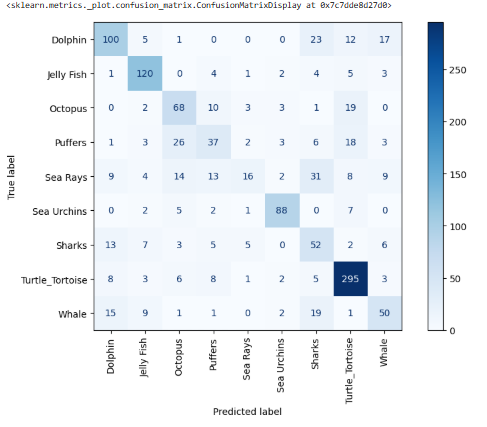

**Create a data set for the test data**

**Task 1.5.20:**

Create a data set for the test data.  It is located in the `sea_creatures/test` directory.  Then create a data loader from this data set.  _DO NOT_ shuffle this data!

In [ ]:
test_dir = os.path.join("sea_creatures/", "test")

test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

print("Number of test images:", len(test_dataset))

test_loader = DataLoader(test_dataset, batch_size=32)

#output
Number of test images: 699


**Make a prediction for each of the test images**

**Task 1.5.21:** Make a prediction for each of the test images.

In [ ]:
# Predict the probabilities for each test image
test_probabilities = predict(model, test_loader, device)

# Get the index associated with the largest probability for each test image
test_predictions = torch.argmax(test_probabilities, dim=1)

print("Number of predictions:", test_predictions.shape)


# output
Number of predictions: torch.Size([699])


**Task 1.5.22:** Convert the class index to the class name for each test image.

In [ ]:
test_classes = [classes[i] for i in test_predictions]

print("Number of class predictions:", len(test_classes))

#output
Number of class predictions: 699

### Final checks

You can now check how accurate your model is by sampling some images from our `/test` directory. These images are not labled, so you'll need to check it manually.

The code below randomly samples 12 images from the test directory and shows them in a grid alongside its predicted label. Run it as many times as you want to get different samples.

How is it working?

In [ ]:
import matplotlib.pyplot as plt
import random

# Sample 12 random indices from the test dataset
sample_indices = random.sample(range(len(test_loader.dataset.samples)), 12)

# Create a grid of 4x3 subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 10))

# Iterate over the sampled indices and plot the corresponding images
for ax, idx in zip(axes.flatten(), sample_indices):
    image_path = test_loader.dataset.samples[idx][0]
    img = Image.open(image_path)

    # Display the image on the axis
    ax.imshow(img)
    ax.axis('off')

    # Get the predicted class for this image
    predicted_class = test_classes[idx]

    # Set the title of the subplot to the predicted class
    ax.set_title(f"Predicted: {predicted_class}", fontsize=14)

plt.tight_layout()

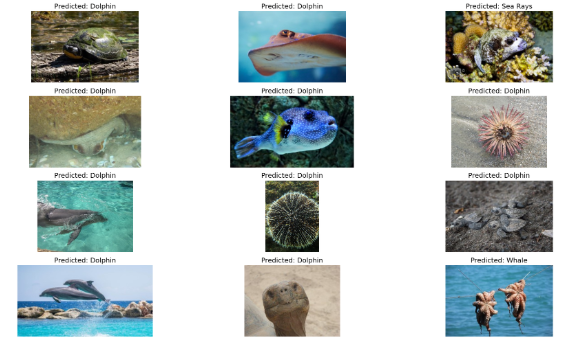